# 5. Variational Eigensolver (VQE) Algorithm

## Installation

In [1]:
# Installation code
!pip install numpy
!pip install qiskit
!pip install 'qiskit[visualization]'
!pip install qiskit-nature
!pip install pyscf
!pip install qutip
!pip install ase
!pip install pyqmc --upgrade
!pip install h5py
!pip install scipy


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user insta

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import array_to_latex, plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere, plot_state_city
from qiskit import QuantumRegister, ClassicalRegister,QuantumCircuit, transpile
from qiskit import execute, Aer
import qiskit.quantum_info as qi
from qiskit.extensions import Initialize
#from qiskit.providers.aer import extensions  # import aersnapshot instructions
from qiskit import Aer
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import QubitConverter
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer
from qiskit_nature import settings
from qiskit.providers.aer import StatevectorSimulator
from qiskit import Aer
from qiskit.primitives import Sampler
from qiskit.algorithms import HamiltonianPhaseEstimation, PhaseEstimation
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SLSQP, SPSA, QNSPSA
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.circuit.library import TwoLocal
from functools import partial as apply_variation

from pyscf import gto, scf
import pyqmc.api as pyq
import h5py
from ase import Atoms
from ase.build import molecule
from ase.visualize import view
import cmath
import math
import scipy.stats as stats
import qutip
import time, datetime
import pandas as pd
import os.path

/Users/yoonho/Library/Python/3.9/lib/python/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


## 5.1. Variational method

### 5.1.1. The Rayleigh-Ritz variational theorem

Rayleigh-Ritz variational theorem이 말하고자 하는것은 어떤 계의 헤밀토니안 $\hat H$ 의 어떤 임의의 파동함수로 표현되는 어떤상태에 대한 기댓값은 언제나 바닥상태 에너지 $(E_0)$보다는 크다는것을 의미한다. 즉, 이를 수식으로 표현하면 아래와 같다. 
$$E_\Psi = \langle \Psi \vert E \vert \Psi \rangle = \frac{\int \Psi^\dagger \hat H \Psi d\tau}{\int \Psi^\dagger  \Psi d\tau} \geq E_0$$

여기서 적분변수 $\tau$ 는 일반적인 시간, 공간 혹은 스핀 등의 변수를 의미한다. 여기까지의 표현은 아직 어떤 화학적인 제한은 없다. 


위의 식을 증명해보자. 
헤밀토니안에 대해 Completeness Relation 을 사용할것이다. 즉, Hermitian 연산자에대해 언제나 orthonormal 한 basis를 가진다는것을 이용해 전개해볼것이다. 즉,
$$\hat H \vert e_i \rangle = E_i \vert e_i \rangle$$
로부터 아래의 관계식 (Completeness Relation)을 얻을 수 있다. 
$$\hat H = \sum_{i=0}^K E_i \vert e_i \rangle \langle e_i \vert  $$

이 헤밀토니안의 orthonormal 한 basis ($e_i$) 는 Complete 하므로 

e_i 를 통해 어떤 임의의 상태를 표현 할 수 있다. 
$$\vert \Psi_{arbitrary} \rangle = \sum_{k=0}^K c_k \vert e_k \rangle $$
여기서 $c_k = \vert e_k \vert \Psi \rangle$ 이고, 정규화 조건을 만족한다. $\langle \Psi \vert \Psi \rangle = \sum_{k=0}^K {\vert c_k \vert}^2 =1$

이렇게 정의를 해두고 앞의 우리가 보고자했던 헤밀토니안의 기댓값 식 ($\langle \Psi \vert E \vert \Psi \rangle$)에 대입해보자

$$\langle \Psi \vert \hat H \vert \Psi \rangle = \sum_{k=0}^K \langle {c_k}^* e_k \vert \hat H \vert c_k e_k \rangle = \sum_{k=0}^K {c_k}^* c_k \langle  e_k \vert \hat H \vert  e_k \rangle =\sum_{k=0}^K {c_k}^* c_k E_k \langle  e_k \vert e_k \rangle =  \sum_{k=0}^K  E_k {|c_k|}^2 \geq E_0$$

거의다 왔다. $c_k $ 와 $\vert e_k \rangle$ 과, k가 이제 무슨 의미인지를 알아보자. 

$e_k$ 는 Hamiltonian $\hat H $ 의 basis로 정의하였다. 그리고 k번째 basis 와 hamiltonian의 내적값은 k번째 에너지이다. (낮은순서대로)

그래서 $c_0$ 가 1이고, 나머지 $c_k (k \neq 0)$ 가 0일때, 우리가 보고자하는 상태의 헤밀토니안의 기댓값은 바닥상태 에너지 $E_0$이고, 이 이외의 경우에는 무조건 $E_0$ 보다는 큰 에너지를 가지게된다. 즉 아래의 식으로 표현 할 수 있다. 

$$E_\Psi = \frac{\langle \Psi \vert \hat H \vert \Psi \rangle} {\langle \Psi \vert \Psi \rangle} \geq \frac{\langle \Psi_0 \vert \hat H \vert \Psi_0 \rangle} {\langle \Psi_0 \vert \Psi_0 \rangle} = E_0$$

물론 최소를 찾으려면, 파동함수를 구성하는 파라미터들로 미분을 통해 구할 수 있다. 

이 변분 Thrm. (Rayleigh-Ritz variational theorem)은, 분자 전자구조의 헤밀토니안에서는 만족한다. 

### 5.1.2. Variational Monte Carlo (VMC) methods

VMC 방식은 앞서 설명한 Rayleigh-Ritz variational theorem 과 and Monte Carlo integration methods을 기반으로 만들어졌다. 

변분원리에서 이러한 약속은 분자 전자구조의 헤밀토니안에서는 만족한다.  

이러한 방식에서 에너지의 기댓값을 먼저 쓰고 시작하겠다. 
$$E_\Psi = \langle \Psi \vert E \vert \Psi \rangle = \underline{ \frac{\int {\vert \Psi \vert}^2 [\Psi^{-1} \hat H \Psi] d\tau}{\int {\vert \Psi \vert}^2 d\tau}}\geq E_0$$

저 밑줄친 부분이 기존의 Rayleigh-Ritz variational theorem 과 달라졌다. 저건 약간의 식조작을 통해 얻어진다. 

기존의 Rayleigh-Ritz variational theorem 에서 
$$E_\Psi = \langle \Psi \vert E \vert \Psi \rangle = \frac{\int \Psi^\dagger \hat H \Psi d\tau}{\int \Psi^\dagger  \Psi d\tau} \geq E_0 --- (기존의 Rayleigh-Ritz variational theorem)$$

아래의 두 정의를 사용하여 식을 정리하게된다.

$$\Psi^\dagger  \Psi ={\vert \Psi \vert}^2 $$
$$\Psi^{-1} \Psi = \mathbb{I} $$

그렇게 되면 아래와 같이 우리가 VMC 에서 정의한 형태를 얻을 수 있다. 
$$ \frac{\int \Psi^\dagger \hat H \Psi d\tau}{\int \Psi^\dagger  \Psi d\tau} = \frac{\int \Psi^\dagger \textcolor{red}{\mathbb{I}} \hat H \Psi d\tau}{\int \Psi^\dagger  \Psi d\tau} = \frac{\int \Psi^\dagger \textcolor{red}{\mathbb{ \Psi} \Psi^{-1}} \hat H \Psi d\tau}{\int \Psi^\dagger  \Psi d\tau} = \frac{\int {\vert \Psi \vert}^2 [\Psi^{-1} \hat H \Psi] d\tau}{\int {\vert \Psi \vert}^2 d\tau}$$

이러한 형태에서, 적분부분을 아래와 같이 두가지의 형태로 나누어 생각 할 수 있다. 

$$\frac{\int \textcolor{green}{ {\vert \Psi \vert}^2 } \textcolor{lightblue}{[\Psi^{-1} \hat H \Psi]} d\tau}{ \textcolor{green}{\int {\vert \Psi \vert}^2 d\tau}}$$

초록색으로 표현된 부분은, $\frac{특정 에너지의 확률}{전체 확률} $ 로 보고자 하는 시스템에서 특정 에너지를 관측할 확률이고 ($\therefore \textcolor{green}{\frac{{ {\vert \Psi \vert}^2 }}{\int {\vert \Psi \vert}^2 d\tau}} := \mathcal{P}(\tau)$)

하늘색으로 표현된 부분을 특정 $\tau$ 에서의 에너지이다. ($\therefore \textcolor{lightblue}{[\Psi^{-1} \hat H \Psi]} := E(\tau)$)

즉, 우리가 구하고자 하는 기댓값을, 고전적인 확률의 정의로 쓸 수 있다.
$$ E_\Psi = \int  E(\tau) \mathcal{P}(\tau) d\tau $$

이제 이 식에 약간의 근사(Metropilis-Hastings (MH) algorithm)를 가할것이다. 이 근사는, 수학적으로는 연속적인 적분을 이산적인 M개의 점에 대한 급수로 바꾸게 된다. 여기서 적분 항에 들어있던 확률 분포 $\mathcal{P}(\tau) $ 는 $(\tau)_k $로 변하여, 각 k번째 점의 분포를 나타내는 식으로 바뀌게 된다. 

$$ E_\Psi \approx \frac{1}{M} 	\sum_{k=1}^M  E(\tau)_k  $$


확률 분포 $\mathcal{P}(\tau) $ 는 $(\tau)_k $로 바꿀때  Markov chain Monte Carlo (MCMC) 방식을 사용하여 확률 분포를 M점들의 분포로 바꾸게 된다. 

예시로 아래의 확률분포를 샘플링 해보자. 
     $$ \mathcal{P}(x) = \begin{cases}
            0, & x < 0 \newline
            e^{-x}, & x \geq 0 
            \end{cases} $$

여기서 MH 알고리즘과 "랜덤워크" 커널 (y = x + N(0,1)) (N : 정규분포), 그리고 수용 확률은 $A = min (1, \frac{\mathcal{p}(y)}{\mathcal{p}(x_t)})$ 을 사용한다. 

이 예제 코드는 아래와 같다. 

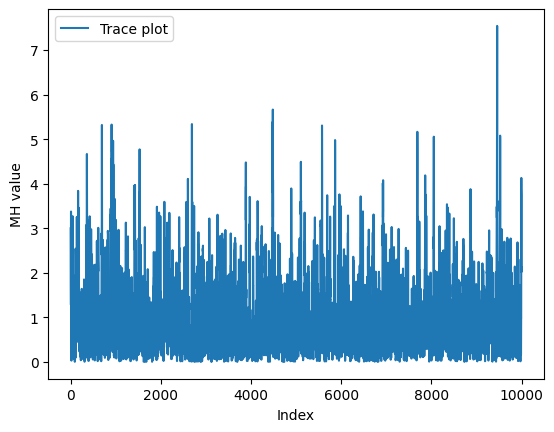

In [3]:
def p(x):
  if x < 0:
    y = 0
  else:
    y = np.exp(-x)
  return(y)

n = 10000 # Size of the Markov chain stationary distribution

# Use np.linspace to create an array of n numbers between 0 and n
index = np.linspace(0, n, num=n)
x = np.linspace(0, n, num=n)

x[0] = 3     # Initialize to 3
for i in range(1, n):
  current_x = x[i-1]

  # We add a N(0,1) random number to x
  proposed_x = current_x + stats.norm.rvs(loc=0, scale=1, size=1, random_state=None)

  A = min(1, p(proposed_x)/p(current_x))

  r = np.random.uniform(0,1) # Generate a uniform random number in [0, 1]

  if r < A:
    x[i] = proposed_x       # Accept move with probabilty min(1,A)
  else:
    x[i] = current_x        # Otherwise "reject" move, and stay where we are

plt.plot(index, x, label="Trace plot")
plt.xlabel('Index')
plt.ylabel('MH value')
plt.legend()
plt.show()

위 그림은, 각 k 점이 어떤 x값(MH value) 를 가지는지 나타내는 그림이다. 

즉, 확률 분포를 M개의 k점의 분포로 변환 하였다. 

이러한 확률분포를 통해 주어진 샘플에서, 최적의 bin의 width 를 찾기위한 Freedman–Diaconis rule 을 이용해 최적의 bin 값을 계산한다.
$$ Bin width = \frac {2IQR(x)}{\sqrt{N}^{1/3}}$$


In [4]:
q25, q75 = np.percentile(x, [25, 75]) #계산에 필요한 사분위수의 범위(IQR)의 두배 를 계산한다. 
bin_width = 2 * (q75 - q25) * len(x) ** (-1/3) #Freedman–Diaconis rule 을 이용해 최적의 bin 값을 계산한다.
bins = round((x.max() - x.min()) / bin_width) #분포의 최대값과 최솟값의 차이를 bin값으로 나눠 필요한 bin의 개수를 구한다. 
print("Freedman–Diaconis number of bins:", bins)

Freedman–Diaconis number of bins: 82


그럼 아래와 같이 Markov Chain의 x값에 대한 확률 분포 그림을 그려 볼 수 있다. 

그리고 이 그림은, 앞서 정의한 확률분포와 어느정도 비슷하다는것을 알 수 있고, 따라서 markov chain은 분포 $\mathcal{p}(x)$ 에 대해 좋은 근사를 보여준다는 것을 알 수 있다. 

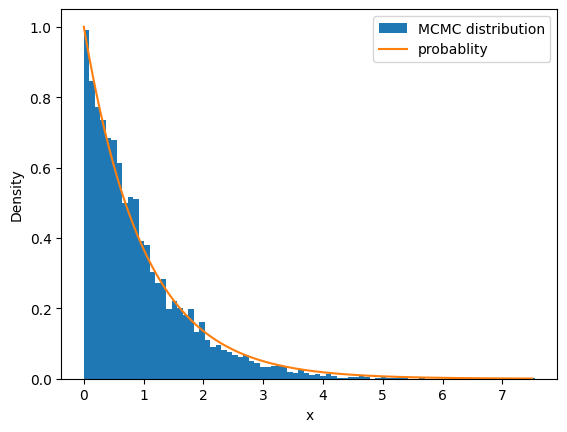

In [5]:
def pp(x):
    return np.exp(-x)
X = np.arange(0,np.max(x),0.05)
plt.hist(x, density=True, bins=bins, label = 'MCMC distribution')
plt.plot(X, pp(X), label='probablity')
plt.ylabel('Density')
plt.xlabel('x')
plt.legend()
plt.show()

In [6]:
def run_PySCF(info_dict, pyqmc=True, show=True):
  # Reset the files
  for fname in ['mf.hdf5','optimized_wf.hdf5','vmc_data.hdf5','dmc.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
  
  atoms = info_dict['atoms']
  coords = info_dict['coords']
  charge = info_dict['charge']
  multiplicity = info_dict['multiplicity']
  atom_pair = info_dict['atom_pair']

  s = ''
  k = 0
  for atom in atoms:
    s += atoms[k] + ' ' + str(coords[k][0]) + ' ' + str(coords[k][1]) + ' ' + str(coords[k][2]) + '; '
    k += 1
  s = s[0:-2]
  
  mol_PySCF = gto.M(atom = s)  
  mf = scf.RHF(mol_PySCF)
  mf.chkfile = "mf.hdf5"
  
  conv, e, mo_e, mo, mo_occ = scf.hf.kernel(mf)
  if show:
    if conv:
      print("PySCF restricted HF (RHF) converged ground-state energy: {:.12f}".format(e))
    else:
      print("PySCF restricted HF (RHF) ground-state computation failed to converge")

  if pyqmc:
    pyq.OPTIMIZE("mf.hdf5",# Construct a Slater-Jastrow wave function from the pyscf output
      "optimized_wf.hdf5", # Store optimized parameters in this file.
      nconfig=100,         # Optimize using this many Monte Carlo samples/configurations
      max_iterations=4,    # 4 optimization steps
      verbose=False)

    with h5py.File("optimized_wf.hdf5") as f:
      iter = f['iteration']
      energy = f['energy']
      error = f['energy_error']
      l = energy.shape[0]
      e = energy[l-1]
      err = error[l-1]
      if show:
        if err < 0.1:
          print("Iteration, Energy, Error")
          for k in iter:
            print("{}:         {:.4f} {:.4f}".format(k, energy[k], error[k]))
          print("PyQMC Monte Carlo converged ground-state energy: {:.12f}, error: {:.4f}".format(e, err))
        else:
          print("PyQMC Monte Carlo failed to converge")

  return conv, e

### 5.1.3. Quantum Phase Estimation (QPE)

양자 화학적인 계산에서, 화학반응에서의 각 분자간의 전체 전기적 에너지의 계산은 매우 높은정밀도를 필요로한다. 

여기서 "Quantum Phase Estimation (QPE)" 알고리즘은 주어진 오차 내에서 양자적인 시뮬레이션을 가능하게 하는 매우 유니크한 특성을 가진다. 

이 알고리즘이 미래에 만들어질 Fault-tolerant 양자컴퓨터가 만들어졌을때 매우 효율적으로 사용할 중요한 알고리즘 중 하나이다. (아직 NISQ에서는 불가능하다.) 

고유상태가 $\vert \psi \rangle $ 로 주어지고, 그의 고유치가 $e^{2 \pi i \theta}$ 로 주어지는 어떤 유니터리 연산자가 있다고 하자. 그럼 아래의 고유치 문제를 만들 수 있을것이다. 
$$ U\vert \psi \rangle =e^{2 \pi i \theta} \vert \psi \rangle $$

상태 $\vert \psi \rangle $ 를 준비하고, 그 상태에 U 를 가하는데에 QPE 알고리즘은 $2^n \theta$ 를 계산하게된다. (여기서 n은 $ \theta $ 를 추정하는데에 사용하느 큐비트의 개수이다. 그리고 $\theta$ 에 해당하는 만큼 원하는 정확도를 얻을 수 있다.)




모든 게이트는 사실 양자역학적인 Time Evolution이다. 

그리고 그 Time Evolution은 아래와같이 Shrodinger 방정식으로 기술 된다. 
$$i\hbar \frac{d}{dt} \vert \psi \rangle = \hat H \vert \psi \rangle$$

이 방정식에서 $\hat H$ 이 시간에 무관한 경우의 솔루션은 아래와 같다. 
$$ \vert \psi \rangle = e^{\frac{t}{ih} \hat H}\vert \psi_0 \rangle$$
$$where,  \vert \psi_0 \rangle  = Initial Condition (or some steady state)$$
여기서 아래와 같이 "time evolution" 연산자 $U(t)$ 를 정의하게 되면
$$ U(t) =: e^{\frac{t}{ih} \hat H}$$
임의의 시간(t)에 대한 상태 $\vert \psi(t) \rangle$ 는 아래와 같은 Time Evolution으로 나타낼 수 있다. 
$$\vert \psi(t) \rangle = \hat U(t) \vert \psi_0 \rangle $$

이제 이러한 이론적인 정의를 바탕으로 Qikit에서 제공하는 QPE 클래스를 이해해보자. 

1) $\hat U(\theta)$ 를 정의한다. 
    이때 $\hat U(\theta)$ 아래의 식을 만족하다. 
    $$U(\theta)\vert q_0 \rangle = e^{2 \pi i \theta} \vert q_0 \rangle = p(2\pi \theta)\vert q_0 \rangle $$
    여기서 $p(\lambda)$ 는 Phase gate로 아래의 행렬형태를 가진다. 
    $$p(\lambda)= \begin{pmatrix} 1 & 0 \\ 0 & e^{i\lambda} \end{pmatrix}$$

    이 P gate를 이용해 $U(\theta)$ 를 코드로 정의해보자. 

In [7]:
def U(theta):
  unitary = QuantumCircuit(1)
  unitary.p(np.pi*2*theta, 0)
  return unitary

이제 본격적으로 QPE 를 해볼것인데, 
Qiskit에서 제공하는 QPE 클래스에서는 아래의 3개의 파라미터가 필요하다. 

1) Unitary : Time evolution 과 관련된 연산자를 어떤 연산자를 사용할 것인가. 
2) nqubit : 큐비트의 수 ; 여기서는 3으로 정의한다. 
3) show (boolean) : QPE 이후의 위상 변화를 보여준다.

이를 이용해 do_qpe 함수를 만들자. 

In [21]:
def do_qpe(unitary, nqubits=3, show=True):
  state_in = QuantumCircuit(1)
  state_in.x(0)
  pe = PhaseEstimation(num_evaluation_qubits=nqubits, sampler = Sampler())
  result = pe.estimate(unitary, state_in)
  phase_out = result.phase
  if show:
    print("Number of qubits: {}, QPE phase estimate: {}".format(nqubits, phase_out))
  return(phase_out)

In [39]:
#이 함수를 이용해 테스트를 해보자. 
theta = 0
for k in range(10):
    r = (1/2)**(k+1)
    theta += r


print("theta: {}".format(theta))
unitary = U(theta)
result = do_qpe(unitary, nqubits=6)

theta: 0.9990234375
Number of qubits: 6, QPE phase estimate: 0.0


위의 코드에서 Theta 의 크기 부분이나, 큐비트의 개수를 조절하며 확인해보면 
큐비트의 개수와 계산값의 오차가 연관되어있는것을 알 수 있다. 

### 5.1.4. Description of the VQE algorithm

##### Figure - VQE Algorithm

#### Trial wavefunctions

## 5.2. Example chemical calculations

In [8]:
# Example chemical calculations

### 5.2.1. Hydrogen molecule

In [9]:
# H2 molecule

##### Figure - Ground state of the $H_2$ molecule with VQE using the Two-Local circuit and SLSQP

In [10]:
# H2 molecule

#### Computing the BOPES

In [11]:
# BOPES of H2

### 5.2.2. Lithium hydride molecule

In [12]:
# LiH molecule

### Varying the lithium hydride molecule

In [13]:
# Vary LiH

### Solving for the Ground-state

In [14]:
# Ground state for LiH

##### Figure 5.15 - Ground state of the $LiH$ molecule with VQE using the Two-Local circuit and SLSQP

In [15]:
# SLSQP LiH

#### Computing the Born-Oppenheimer Potential Energy Surface (BOPES)

In [16]:
# BOPES LiH

### 5.2.3. Marcro molecule

In [17]:
# Macro Molecule

#### ASE atomic visulization

##### Figure - Macro Molecule

In [18]:
#Macro Molecule

### Solving for the Ground-state

In [19]:
#Ground State for Macro Molecule

### Computing the BOPES

In [20]:
# BOPES of Macro Molecule

## Summary